In [147]:
! pip install albumentations==0.4.6

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle as pk
import cv2 as cv2
from PIL import Image 
import albumentations as Ab
from albumentations.pytorch import ToTensorV2
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms


In [148]:
class Block(nn.Module):

    def __init__(self, in_features, out_features, down = True, activ = "relu", dropout = False, device = "cuda" ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_features, out_features, 4, 2, padding = 1, device = device) if down
            else
            nn.ConvTranspose2d(in_features, out_features, 4, 2, padding = 1, device = device),
            nn.BatchNorm2d(out_features, device = device),
            nn.ReLU(True) if activ == "relu"
            else nn.LeakyReLU(0.2,True),
        )
        self.dropout = nn.Dropout(0.5)
        self.dropout_exist = dropout
    
    def forward(self, x):
        x = self.net(x)
        if(self.dropout_exist):
            x = self.dropout(x)
        
        return x


In [149]:
class Generator(nn.Module):

    def __init__(self,device = "cuda", in_dim = 1, features = 64):
        super().__init__()
                            #input image is 256x256 during training and 512x512 at testing
        self.e1 = nn.Sequential(                                                    #42
            nn.Conv2d(in_dim, features, 4,2,padding=1, device = device),
            nn.LeakyReLU(0.2,True),
        )
        self.e2 = Block(features,2*features,True,activ="LeakyReLU",device=device)   #21
        self.e3 = Block(features*2,features*4,True,activ="LeakyReLU",device=device) #
        self.e4 = Block(features*4,features*4,True,activ="LeakyReLU",device=device)
        self.e5 = Block(features*4,features*4,True,activ="LeakyReLU",device=device)
        self.e6 = Block(features*4,features*4,True,activ="LeakyReLU",device=device)
        #self.e7 = Block(features*4,features*4,True,activ="LeakyReLU",device=device)
        #self.e8 = Block(features*4,features*4,True,activ="LeakyReLU",device=device)

        #self.d8 = Block(features*4,features*4,False,"relu",True,device)
        #self.d7 = Block(features*4,features*8,False,"relu",True,device=device)
        self.d6 = Block(features*4,features*4,False,"relu",True,device=device)
        self.d5 = Block(features*8,features*4,False,"relu",True,device=device)
        self.d4 = Block(features*8,features*4,False,"relu",True,device=device)
        self.d3 = Block(features*8,features*2,False,"relu",True,device=device)
        self.d2 = Block(features*4,features*1,False,"relu",True,device=device)
        self.d1 = Block(features*2,features,False,"relu",True,device=device)

        self.final_layer = nn.Sequential(
            nn.Conv2d(features,2,kernel_size=3,stride=1,padding=1,device = device),
            nn.Tanh()
        )

    def forward(self,x):
        #print(x.size())

        x1 = self.e1(x)
        #print(1)
        x2 = self.e2(x1)
        #print(2)
        x3 = self.e3(x2)
        #print(3)
        x4 = self.e4(x3)
        #print(4)
        x5 = self.e5(x4)
        #print(5)
        x6 = self.e6(x5)
        #print(6)
        #x7 = self.e7(x6)
        #x8 = self.e8(x7)

        #u8 = self.d8(x8)
        #u7 = self.d7(torch.cat(u7,e7),-1)
        u6 = self.d6(x6)
        #print(6)
        u5 = self.d5(torch.cat([u6,x5],1))
        #print(5)
        u4 = self.d4(torch.cat([u5,x4],1))
        #print(4)
        u3 = self.d3(torch.cat([u4,x3],1))
        #print(3)
        #print(u3.size())
        #print(x2.size())
        u2 = self.d2(torch.cat([u3,x2],1))
        #print(2)
        u1 = self.d1(torch.cat([u2,x1],1))
        #print(1)

        out = self.final_layer(u1)
        #print(out.size())
        return out

In [150]:
class Discriminator(nn.Module):
    
    def __init__(self, device = "cuda"):

        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,64,4,2,padding=1,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,128,4,2,padding=1,device=device),
            nn.BatchNorm2d(128,device = device),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128,256,4,2,padding=1,device=device),
            nn.BatchNorm2d(256,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(256,512,4,2,padding=1, device=device),
            nn.BatchNorm2d(512,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(512,1,4,1,padding=1, device=device),
        )

    def forward(self,x,y):
        z = torch.cat([x,y],1)

        z = self.net(z)
        z = torch.sigmoid(z)
        return z


In [151]:

def test_gen():
    x = torch.randn((1, 1, 256, 256))
    model = Generator(device = "cpu")
    preds = model(x)
    print(preds.shape)

def test_disc():
    x = torch.randn((1, 2, 256, 256))
    y = torch.randn((1, 1, 256, 256))
    model = Discriminator(device = "cpu")
    preds = model(x, y)
    print(model)
    print(preds.shape)



In [152]:
x = torch.ones((64,1,84,84))
y = torch.ones((64,3,84,84))

torch.cat([x,y],1).size()
#torch.cat((x,x,x),1).size()

torch.Size([64, 4, 84, 84])

In [153]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [154]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Kaggle_ImageNet'

In [155]:
%cd /content/gdrive/MyDrive/Kaggle_ImageNet

/content/gdrive/MyDrive/Kaggle_ImageNet


In [156]:
!ls


ImageNet  kaggle.json


In [157]:
%cd ImageNet

/content/gdrive/MyDrive/Kaggle_ImageNet/ImageNet


In [158]:
from torch.utils.data import Dataset
import os
from skimage import io

class ImageDataset(Dataset):
    def __init__(self, root_dir, bw_dir, length):
        self.root_dir = root_dir
        self.length = length
        self.transform = transforms.Resize((128,128))
        self.transform2 = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, "%s.jpeg"%(index))
        color_image = Image.open(img_path).convert("RGB")
        color_image = self.transform(color_image)

        in_image = rgb2lab(color_image).astype("float32")
        in_image = self.transform2(in_image)

        bw = in_image[[0], ...] / 50 -1     # to be fed into Generator
        clrd = in_image[[1,2], ...] / 110   # corresponds to Generators's output

        #print("Shape to be fed into Generator : ", end = " ")
        #print(bw.shape)
        #print("Shape Corresponding to Generator's output : ", end = " ")
        #print(clrd.shape)
        return {'bw':bw, 'clrd': clrd}
      

In [159]:
train_size = 38400
test_size = 12000

train_dataset = ImageDataset(root_dir = "/content/gdrive/MyDrive/Kaggle_ImageNet/ImageNet/TrainSet", bw_dir = "/content/gdrive/MyDrive/Kaggle_ImageNet/ImageNet/Train_BW" , length=train_size)
test_dataset = ImageDataset(root_dir = "/content/gdrive/MyDrive/Kaggle_ImageNet/ImageNet/TestSet", bw_dir = "/content/gdrive/MyDrive/Kaggle_ImageNet/ImageNet/a2_Set", length=test_size,)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 1, shuffle=True, num_workers= 2)


In [160]:
#Model Declaration and device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

Disc = Discriminator(device=device)
Gen = Generator(device=device)
Gen.to(device)
Disc.to(device)

cuda:0


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [161]:
#parameters and cost function
import torch.optim as optim

lr = 0.0002
opt_disc = optim.Adam(Disc.parameters(), lr = lr, betas=(0.5,0.999))
opt_gen = optim.Adam(Gen.parameters(), lr = lr, betas=(0.5,0.999))

BCE = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()


torch.Size([1, 1, 128, 128])
torch.Size([1, 2, 128, 128])


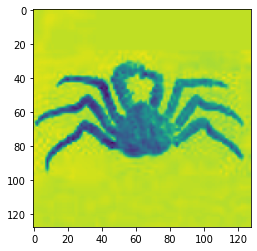

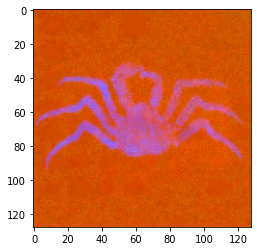

In [162]:
#Training
from tqdm import tqdm
import torchvision.transforms.functional as F

testiter = iter(test_loader)

for epoch in range(8):

    totalG_loss = 0
    totalD_loss = 0

    i = 0
    j = 0

    for data in train_loader:

        clrd , bw = data['clrd'].to(device), data['bw'].to(device)
        clrd_fake = Gen(bw)
        
        D_real = Disc(clrd,bw)
        D_fake = Disc(clrd_fake, bw)
        D_real_loss = BCE(D_real, torch.ones_like(D_real))
        D_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss)/2

        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        totalD_loss += D_loss

        #training for Generator

        clrd_fakeg = Gen(bw)
        D_fake = Disc(clrd_fakeg,bw)
        G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
        L1 = nn.L1Loss()(clrd_fakeg, clrd)*100
        G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        totalG_loss += G_loss

        i += 1

        if(i%50 == 49):
            print("Epoch %s at iteration %s : Total GLoss = %s  And Total Dloss = %s"%(epoch,i,totalG_loss, totalD_loss))
            totalG_loss = 0
            totalD_loss = 0
        







        
        

Epoch 0 at iteration 49 : Total GLoss = tensor(692.8132, device='cuda:0', grad_fn=<AddBackward0>)  And Total Dloss = tensor(15.8188, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0 at iteration 99 : Total GLoss = tensor(513.6583, device='cuda:0', grad_fn=<AddBackward0>)  And Total Dloss = tensor(15.6812, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0 at iteration 149 : Total GLoss = tensor(504.8936, device='cuda:0', grad_fn=<AddBackward0>)  And Total Dloss = tensor(15.6719, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0 at iteration 199 : Total GLoss = tensor(495.9637, device='cuda:0', grad_fn=<AddBackward0>)  And Total Dloss = tensor(15.6685, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0 at iteration 249 : Total GLoss = tensor(512.9095, device='cuda:0', grad_fn=<AddBackward0>)  And Total Dloss = tensor(15.6669, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0 at iteration 299 : Total GLoss = tensor(488.6513, device='cuda:0', grad_fn=<AddBackward0>)  And Total Dloss = tensor(15

Image no. 1


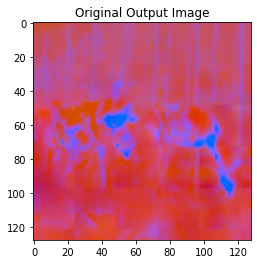

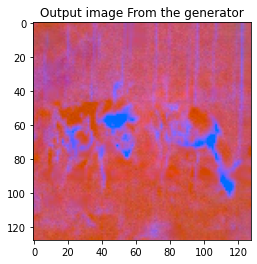

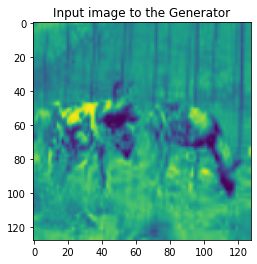

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Image no. 2


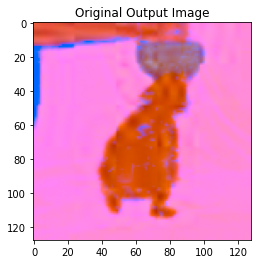

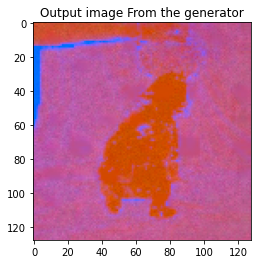

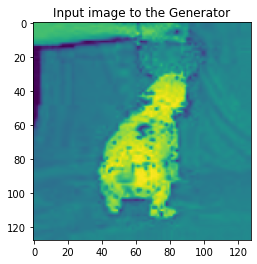

Image no. 3


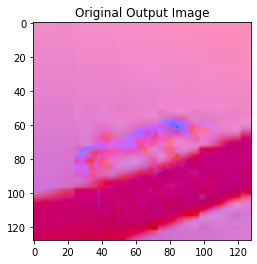

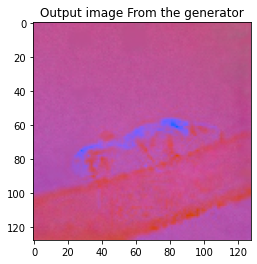

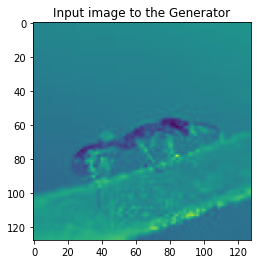

Image no. 4


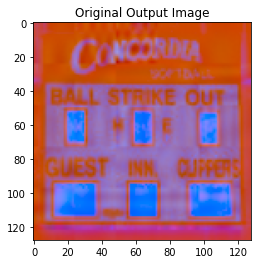

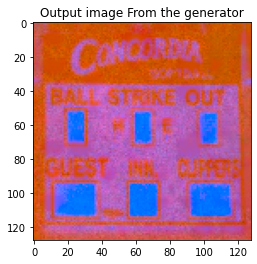

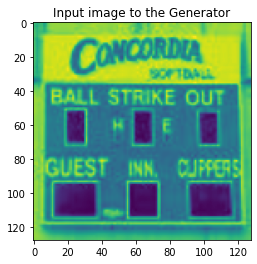

Image no. 5


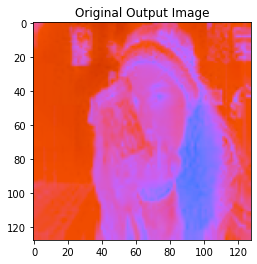

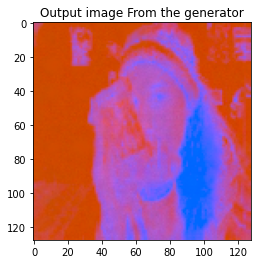

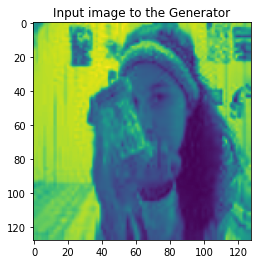

Image no. 6


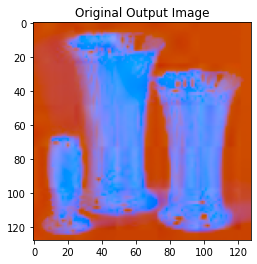

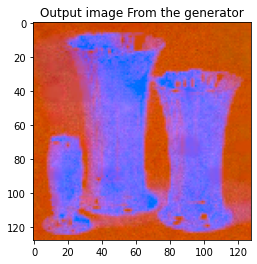

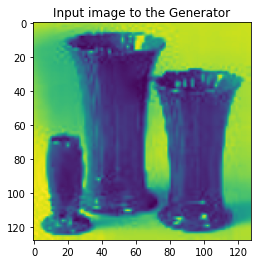

Image no. 7


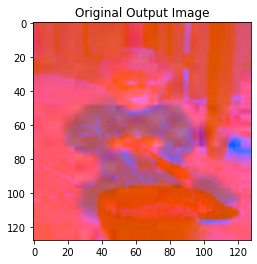

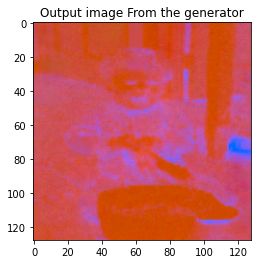

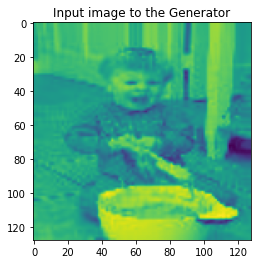

Image no. 8


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 275 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


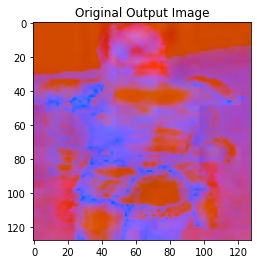

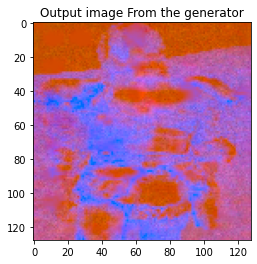

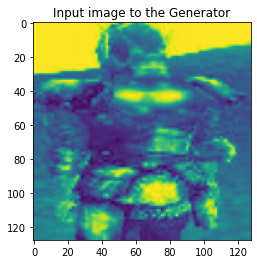

Image no. 9


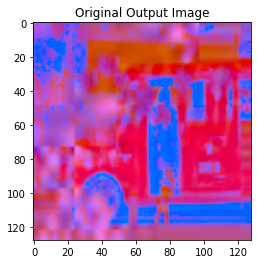

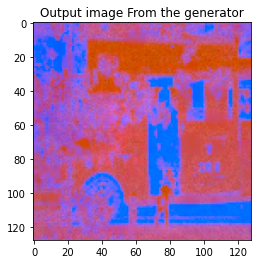

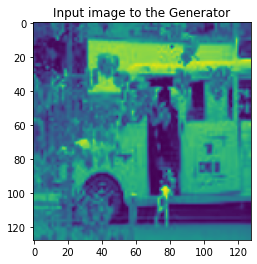

Image no. 10


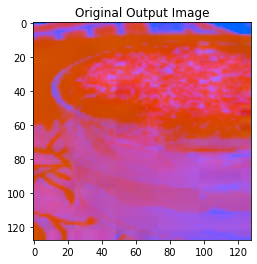

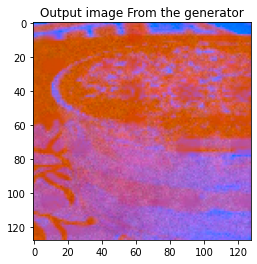

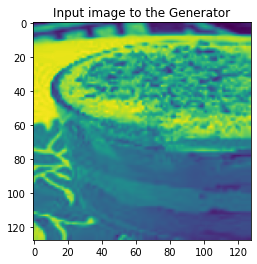

Image no. 11


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


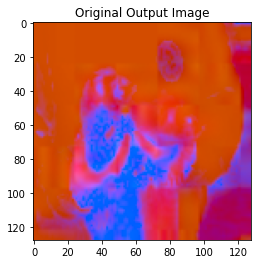

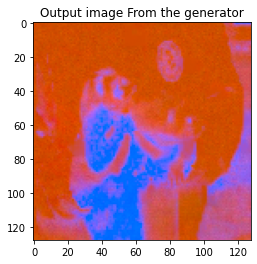

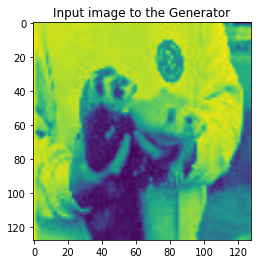

Image no. 12


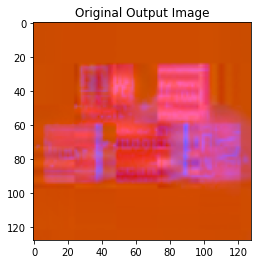

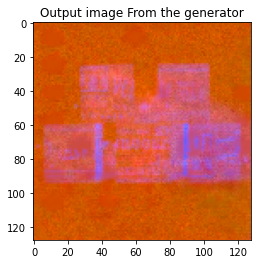

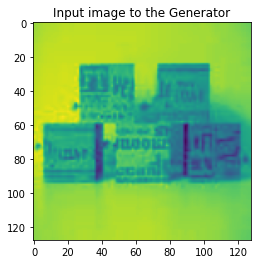

Image no. 13


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


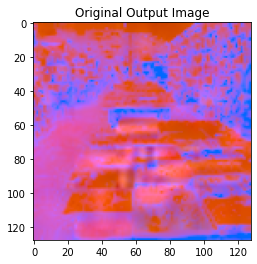

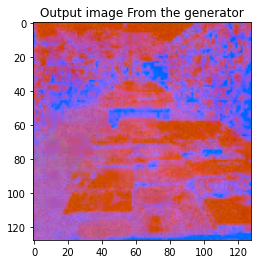

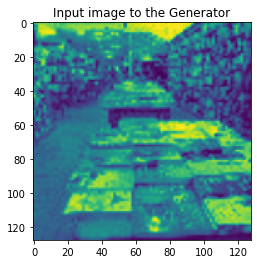

Image no. 14


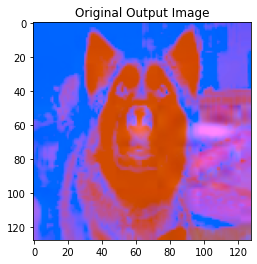

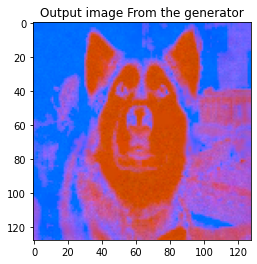

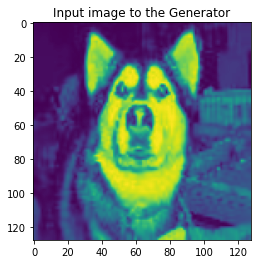

Image no. 15


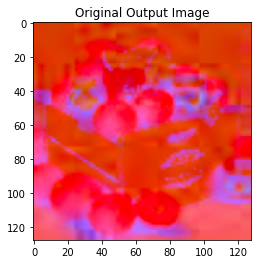

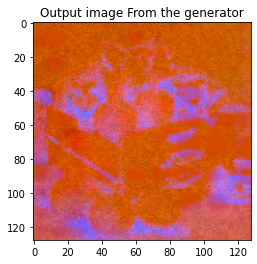

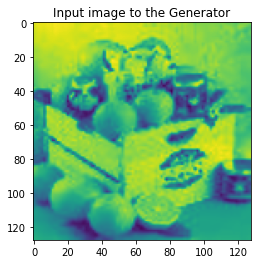

Image no. 16


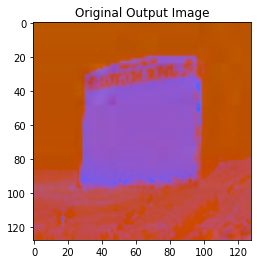

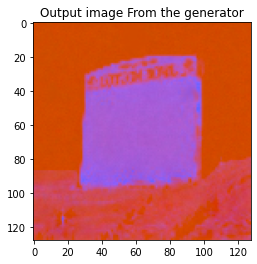

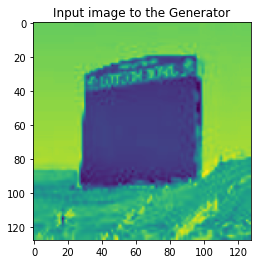

Image no. 17


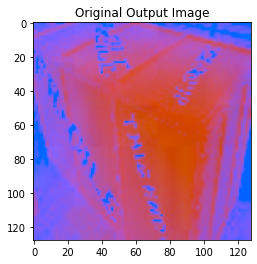

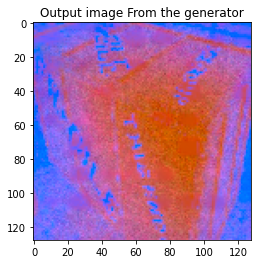

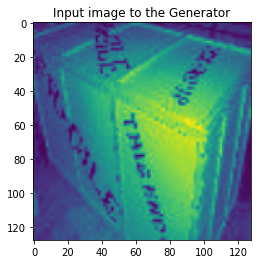

Image no. 18


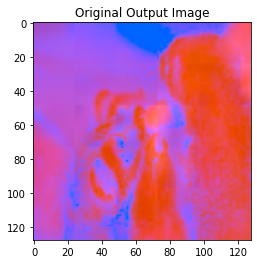

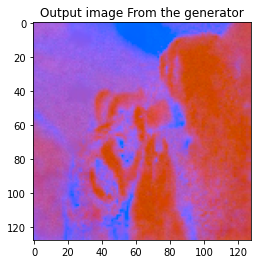

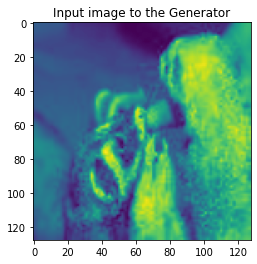

Image no. 19


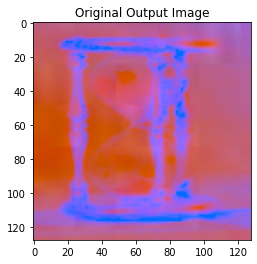

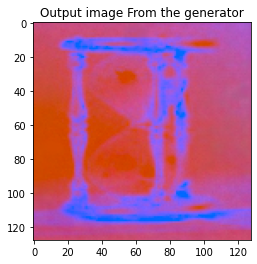

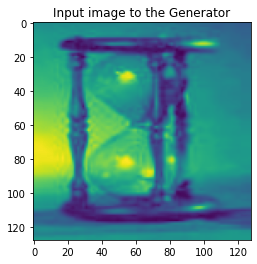

Image no. 20


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 110 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


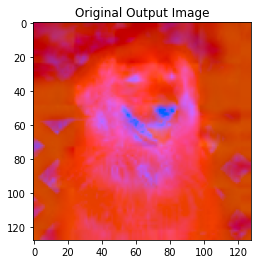

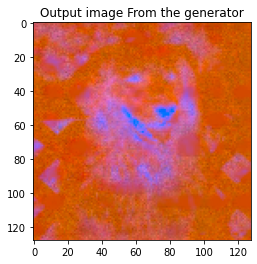

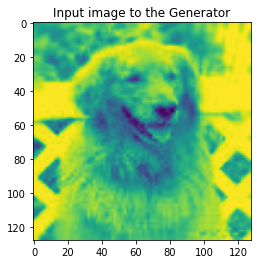

In [178]:
def lab_to_rgb(b, a):
    b = (b+1)*50
    a = a*110

    ba = torch.cat([b,a], dim = 1).permute(0,2,3,1).cpu().numpy()
    ba = ba.reshape((128,128,3))

    ba_rgb = lab2rgb(ba)

    return ba_rgb

testiter = iter(test_loader)

for i in range(20):

    data = testiter.next()
    test_clrd = data['clrd']
    a2 = data['bw']

    a2 = a2.to(device)
    b2 = Gen(a2)

    #b2 = test_clrd

    a2 = a2.detach()
    a2 = a2.to("cpu")
    b2 = b2.detach()
    b2 = b2.to("cpu")

    ba = lab_to_rgb(b2, a2)

    ba = np.squeeze(ba)
    
    print("Image no. %s"%(i+1))

    plt.title("Original Output Image")
    out = lab_to_rgb(test_clrd, a2)
    out = np.squeeze(out)
    out = out.reshape((128,128,3))
    plt.imshow(out)
    plt.show()

    plt.title("Output image From the generator")
    ba = ba.reshape((128,128,3))
    plt.imshow(ba)
    plt.show()

    a2 = torch.squeeze(a2)

    plt.title("Input image to the Generator")
    plt.imshow(a2)
    plt.show()


